In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np


# my data
from dataloaders.osm_datagenerator import DataGeneratorOSM
from dataloaders.dataset_helper import findallimagesosm_nopartition, load_mask_coverage, cov_to_class
from dataloaders.img_helper import show_sample, show_sample_gt

# Ignore warnings
# import warnings
# warnings.filterwarnings("ignore")
import tensorflow as tf
from keras import backend as K
from sklearn.model_selection import train_test_split
from segmentation_models.backbones import get_preprocessing as process_image
#from keras.applications.vgg16 import preprocess_input



Using TensorFlow backend.


In [2]:
# The GPU id to use, usually either "0" or "1";
os.environ["CUDA_VISIBLE_DEVICES"]="0"; 
config = tf.ConfigProto()
session = tf.Session(config=config)
K.set_session(session)

In [3]:
# define backbone since I will do image processing accordingly
BACKBONE = 'resnet34'
preprocess_input = process_image(BACKBONE)

## some distribution visualization + train, validaion, test split

In [4]:
X, y = findallimagesosm_nopartition(folder = '/data/khokhlov/datasets/OSM_processed_margo/')
masks = load_mask_coverage('all.csv')
mask_values = list(masks.values())
mask_classes = np.asarray(mask_values, dtype = np.float32)
for i, s  in enumerate(mask_classes):
    mask_classes[i] = cov_to_class(s)
    
# put all in the contrainer to make it easier to read
train_df = {}  # dict to store the data
train_df["images"] = X
train_df["labels"] = y
train_df["coverage"] = np.asarray(mask_values, dtype = np.float32)
train_df["coverage_class"] = mask_classes


The number of training samples is =  36404, validation samples is = 9101


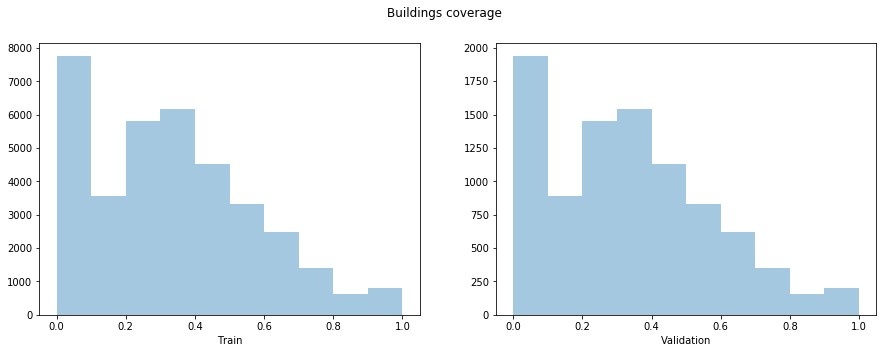

In [5]:
# train and validation splits

X_train, X_val, y_train, y_val,  cov_train, cov_val, cov_cl_train, _ = train_test_split(
    train_df["images"], train_df["labels"], train_df["coverage"], train_df["coverage_class"],
    test_size=0.2, stratify=train_df["coverage_class"], random_state=1234)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(cov_train, bins=10, kde=False, ax=axs[0])
sns.distplot(cov_val, bins=10, kde=False, ax=axs[1])
plt.suptitle("Buildings coverage")
axs[0].set_xlabel("Train")
axs[1].set_xlabel("Validation")
print('The number of training samples is =  %d, validation samples is = %d' % (len(X_train), len(X_val)))


The number of training samples is =  29123, test samples is = 7281


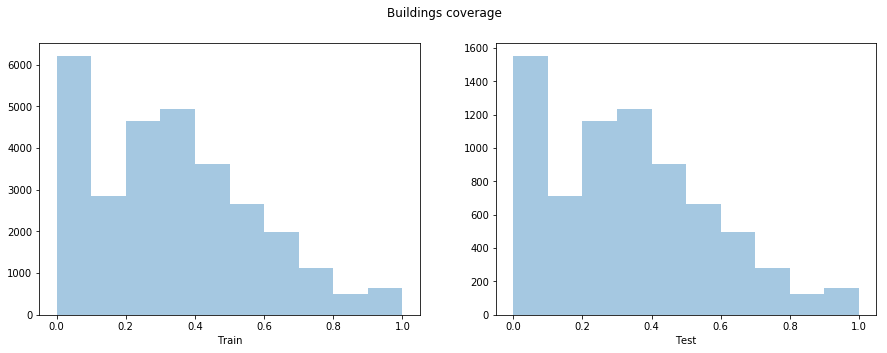

In [6]:
# train and test splits
X_train, X_test, y_train, y_test, cov_train, cov_test = train_test_split(
    X_train, y_train, cov_train,
    test_size=0.2, stratify=cov_cl_train, random_state=12345)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))
sns.distplot(cov_train, bins=10, kde=False, ax=axs[0])
sns.distplot(cov_test, bins=10, kde=False, ax=axs[1])
plt.suptitle("Buildings coverage")
axs[0].set_xlabel("Train")
axs[1].set_xlabel("Test")
print('The number of training samples is =  %d, test samples is = %d' % (len(X_train), len(X_test)))

## data generators + images visualization

In [7]:
# prepare data - my generator is expecting dict as coverage values
dictionary_train = dict(zip(X_train, cov_train))
dictionary_validatation = dict(zip(X_val, cov_val))
# and the labels and images as lists of names
X_train = list(X_train)
y_train = list(y_train)
X_val = list(X_val)
y_val = list(y_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


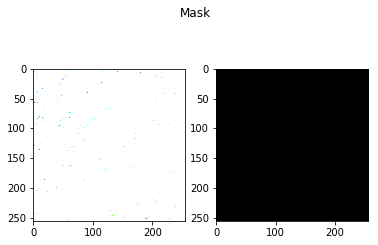

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


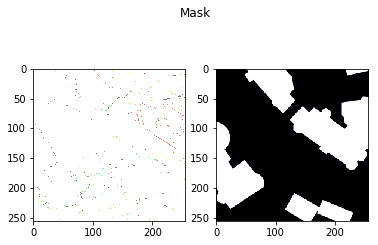

In [16]:
# define parameters for sampling

params = {'dim': (256, 256),
          'batch_size': 42,
          'n_channels_img':3,
          'n_channel_mask':1,
          'shuffle': True}




training_generator = DataGeneratorOSM(X_train, y_train, coverage=dictionary_train, stratified_sampling = True, 
                                      Transform = True, Process_function = preprocess_input, **params)
validation_generator = DataGeneratorOSM(X_val, y_val, Transform = True, Process_function = preprocess_input, **params)

(X,y) = training_generator. __getitem__(0)
show_sample(X[0,:], np.squeeze(y[0,:]))

(X,y) = validation_generator. __getitem__(0)
show_sample(X[0,:], np.squeeze(y[0,:]))


In [17]:
# %load_ext autoreload
# %autoreload 2


# SEGMENTATION MODEL SETTING

In [18]:
# load some dependences
from segmentation_models import Unet
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
from segmentation_models.losses import bce_jaccard_loss
from segmentation_models.metrics import iou_score


In [19]:
 # define model
model = Unet(BACKBONE, encoder_weights='imagenet')
preprocess_input = process_image(BACKBONE)
model.compile('Adam', loss=bce_jaccard_loss, metrics=[iou_score, 'binary_accuracy'])


In [ ]:
#define callbacks
# train parameters
loss_history = []
weight_path = "modelssaved/{}_weights.best.hdf5".format('resnet_unet')
checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min', save_weights_only=True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=5, verbose=1, mode='auto',
                                   epsilon=0.0001, cooldown=5, min_lr=0.0001)
early = EarlyStopping(monitor="val_loss",
                      mode="min",
                      patience=15)  # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint, early, reduceLROnPlat]


In [ ]:
# fit model
with tf.device('/gpu:0'):
    history = model.fit_generator(generator=training_generator, steps_per_epoch=200,
        epochs=25,
        validation_data=validation_generator, validation_steps=20,
        use_multiprocessing=False,
        callbacks=callbacks_list)
    loss_history += history


Epoch 1/25
200/200 [==============================] - 384s 2s/step - loss: 0.9195 - iou_score: 0.4667 - binary_accuracy: 0.8172 - val_loss: 0.9476 - val_iou_score: 0.4280 - val_binary_accuracy: 0.8217

Epoch 00001: val_loss improved from inf to 0.94759, saving model to modelssaved/resnet_unet_weights.best.hdf5
Epoch 2/25
200/200 [==============================] - 353s 2s/step - loss: 0.7991 - iou_score: 0.5299 - binary_accuracy: 0.8483 - val_loss: 0.8571 - val_iou_score: 0.5202 - val_binary_accuracy: 0.8311

Epoch 00002: val_loss improved from 0.94759 to 0.85707, saving model to modelssaved/resnet_unet_weights.best.hdf5
Epoch 3/25
200/200 [==============================] - 328s 2s/step - loss: 0.7741 - iou_score: 0.5384 - binary_accuracy: 0.8557 - val_loss: 0.8078 - val_iou_score: 0.5583 - val_binary_accuracy: 0.8475

Epoch 00003: val_loss improved from 0.85707 to 0.80776, saving model to modelssaved/resnet_unet_weights.best.hdf5
Epoch 4/25
200/200 [==============================] - 31

In [16]:
# visualizing losses and accuracy
train_loss = model.history['loss']
val_loss   = model.history['val_loss']
train_iou_score = model.history['iou_score']
val_iou_score  = model.history['val_iou_score']
binary_accuracy = model.hisory['binary_accuracy']
val_binary_accuracy = model.hisory['val_binary_accuracy']
xc         = range(num_epochs)

plt.figure()
plt.subplot(3, 1, 1)
plt.title('Loss')
plt.plot(xc, train_loss,  'r')
plt.plot(xc, val_loss,  'b')
plt.subplot(3, 1, 2)
plt.title('Intersection Over Union Score')
plt.plot(xc, train_iou_score,  'r')
plt.plot(xc, val_iou_score,  'b')
plt.subplot(3, 1, 3)
plt.plot(xc, binary_accuracy,  'r')
plt.plot(xc, val_binary_accuracy,  'b')


ValueError: need at least one array to concatenate

## Testing 

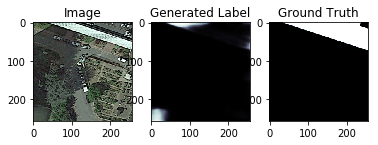

0.0005805857 0.97064936


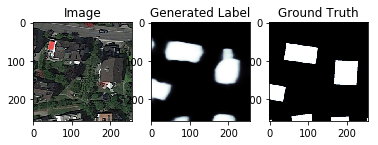

0.00063179206 0.9993482


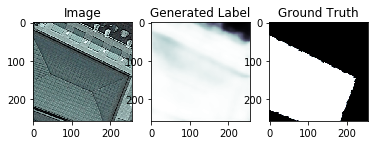

0.01883146 0.99379694


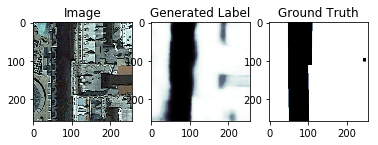

0.0028797593 0.9989833


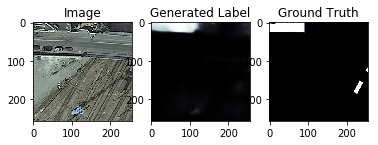

0.0010049662 0.9936392


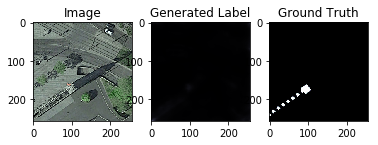

0.00042706882 0.23961605


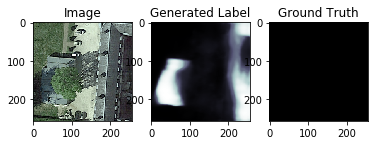

0.0028541826 0.99332494


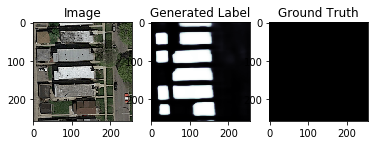

0.0040701358 0.99945575


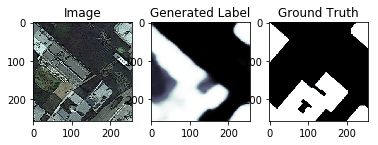

0.0008615875 0.9985813


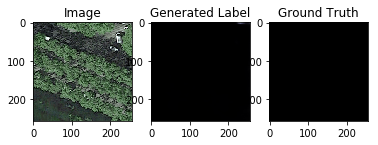

0.0011599316 0.7090523


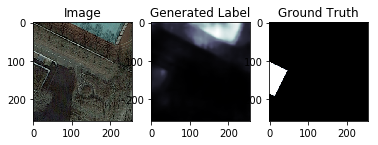

0.0043919007 0.8535697


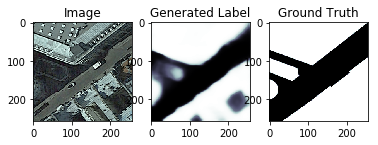

0.0008480112 0.9987079


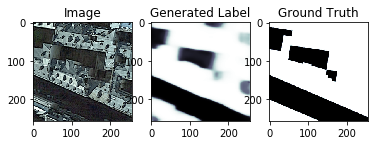

0.00094726525 0.9993923


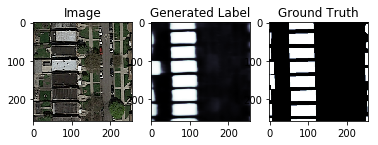

0.0072840415 0.9989593


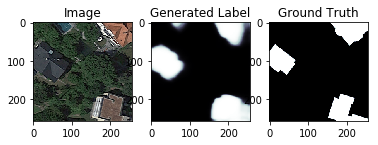

0.0010478062 0.9994584


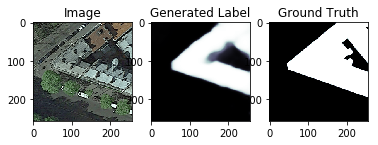

0.00079771073 0.9991248


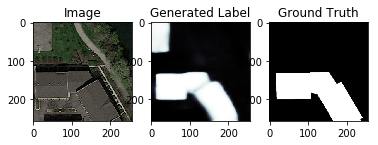

0.0019411405 0.9989814


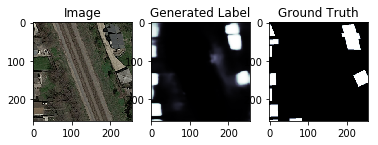

3.7587954e-05 0.9989158


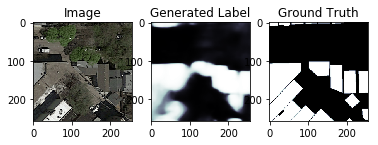

0.0029825424 0.99918896


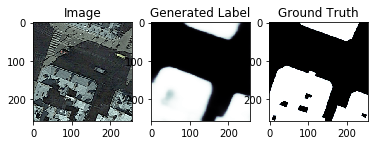

0.00059240893 0.9992785


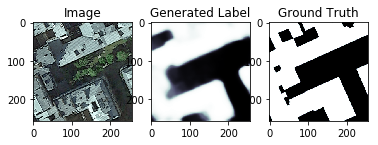

0.001450679 0.9988851


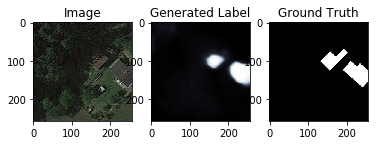

0.004668638 0.9969138


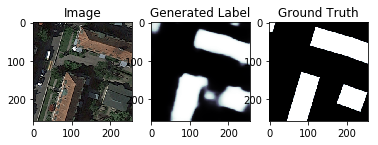

0.0005690793 0.9994797


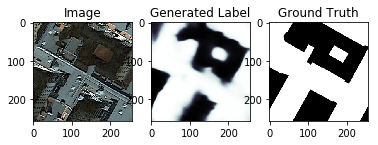

0.009331967 0.999092


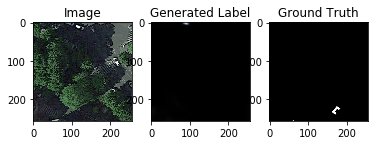

0.00055056886 0.59752613


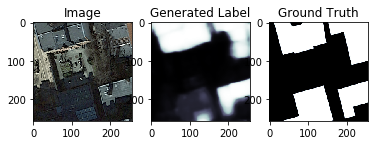

0.003679542 0.99798965


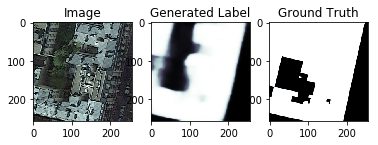

0.00086415926 0.9990262


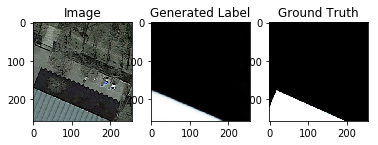

0.0010455273 0.99729


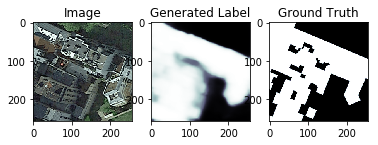

0.001563083 0.9993486


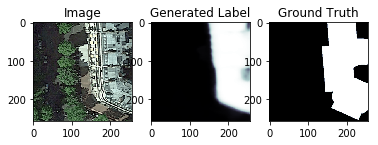

0.00087692164 0.99813986


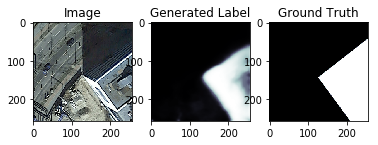

0.0008741636 0.9920292


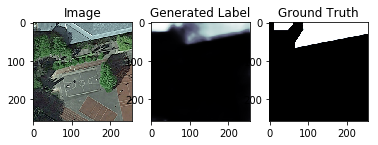

0.0013120114 0.98578644


In [19]:
testing_generator = DataGeneratorOSM(X_test, y_test, Transform = True, Process_function = preprocess_input, **params)
(X,y) = testing_generator. __getitem__(0)
dm_pred =  model.predict([X])
for i in range(dm_pred.shape[0]):
    show_sample_gt(X[i,:].astype(int), np.squeeze(dm_pred[i,:]), np.squeeze(y[i,:]))
    print(dm_pred[i,:].min(), dm_pred[i,:].max())
    

In [21]:
out_parms = model.evaluate_generator(testing_generator , steps = 10)
print('\n')
for k,v in zip(model.metrics_names, out_parms):
    print(k,'%2.2f' % v)
    



loss 0.75
iou_score 0.57
